In [1]:
import antialiased_cnns
import torch
import torchvision

from torchvision import transforms, models
import cv2
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('device', device)

device cuda:0


In [3]:
model_default = antialiased_cnns.resnet50(pretrained=True).to(device)

model_default.eval();
for param in model_default.parameters():
    param.requires_grad = False

model_default._modules.get('avgpool')

AdaptiveAvgPool2d(output_size=(1, 1))

In [2]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
batch_size = 16


princess_dataloader_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder('/home/tesla/tigers_bbox/princess_task_data/train',
                                     val_transforms),
    batch_size=batch_size, shuffle=False, num_workers=batch_size
)

princess_dataloader_val = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder('/home/tesla/tigers_bbox/princess_task_data/val',
                                     val_transforms),
    batch_size=batch_size, shuffle=False, num_workers=batch_size
)

/home/tesla/env/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
! ls trained_models/resnet50/weights_epoch_70.h5

ls: cannot access 'trained_models/resnet50/weights_epoch_70.h5': No such file or directory


In [3]:
def get_embedding(model, x):
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)

    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)

    x = model.avgpool(x)
    x = x.view(x.size(0), -1)
    emb = x
    x = model.fc(x)
    return x, emb

In [4]:
#model_path = 'tigers_bbox/trained_models/resnet50/weights_epoch_77.h5'
model_path = 'tigers_bbox/trained_models/resnet152/weights_epoch_63.h5'


model = antialiased_cnns.resnet152(pretrained=True).to(device)
model.fc = torch.nn.Sequential(
               torch.nn.Linear(2048, 128),
               torch.nn.ReLU(inplace=True),
               torch.nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

for param in model.parameters():
    param.requires_grad = False
model._modules.get('avgpool')

AdaptiveAvgPool2d(output_size=(1, 1))

In [7]:
def collect(loader):
    embdss = []
    ys_true_dogs = []

    metrics = defaultdict(list)
    #time_took = time()

    with torch.no_grad():
        for i, batch in enumerate(loader):
            imgs = batch[0]
            clss = batch[1]
            _, embds = get_embedding(model,imgs.cuda())
            embdss.append(embds.cpu().numpy())
            
            y_true_dogs = clss.cuda().cpu().numpy()
            ys_true_dogs.append(y_true_dogs)
            
    #time_took = time() - time_took
    
    embdss = np.concatenate(embdss, axis=0)
    ys_true_dogs = np.concatenate(ys_true_dogs)

    return embdss, ys_true_dogs

In [8]:
embdss_train, ys_true_train = collect(princess_dataloader_train)

In [9]:
embdss_val, ys_true_val = collect(princess_dataloader_val)

In [10]:
embdss_val.shape

(1142, 2048)

In [11]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier

In [22]:
predictor = KNeighborsClassifier(n_neighbors=1, n_jobs=6, metric='cosine').fit(embdss_train, ys_true_train)

In [17]:
import pickle
with open('predictor_152.pickle', 'wb') as handle:
    pickle.dump(predictor, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
ys_pred_test = predictor.predict(embdss_val)

In [24]:
from sklearn.metrics import balanced_accuracy_score, f1_score
balanced_accuracy_score(ys_true_val, ys_pred_test)

0.9492886945156588

In [25]:
f1_score(ys_true_val, ys_pred_test)

0.9148936170212766

In [51]:
from sklearn.metrics import balanced_accuracy_score, f1_score
balanced_accuracy_score(ys_true_val, ys_pred_test)

0.9320665560750012

In [52]:
f1_score(ys_true_val, ys_pred_test)

0.8829787234042553

In [43]:
embdss_val[0][0].shape

()

In [47]:
predictor.predict(np.expand_dims(embdss_val[1100], axis=0))

array([1])

In [48]:
ys_true_val[1100]

1

In [5]:
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [24]:
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img_ = Image.open('/home/tesla/tigers_bbox/data/cropped/Тигры/001_1001.jpg')
transformed_img = transform(img_)
input_ = transform_normalize(transformed_img)
input_ = input_.unsqueeze(0)
img = input_.cuda()
output = model(img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(img,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)


In [38]:
img_ = cv2.imread('/home/tesla/tigers_bbox/data/cropped/Тигры/001_1001.jpg')
img_show = img_.copy()
img_show = cv2.resize(img_show, (224, 224))
img_show = cv2.cvtColor(img_show, cv2.COLOR_RGB2BGR)
img_ = np.float32(cv2.resize(img_, (224, 224))) / 255
mask_ = np.flip(np.rot90(np.array(attributions_occ.cpu().squeeze()).T, 3),axis=1)
mask_[mask_<0]=0
heatmap = cv2.applyColorMap(np.uint8(255 * mask_), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
cam = cv2.resize(heatmap, (224, 224)) + np.float32(img_)
cam = cam / np.max(cam)
cam = np.uint8(255 * cam)
cam = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
vis = np.concatenate((img_show, cam), axis=1)

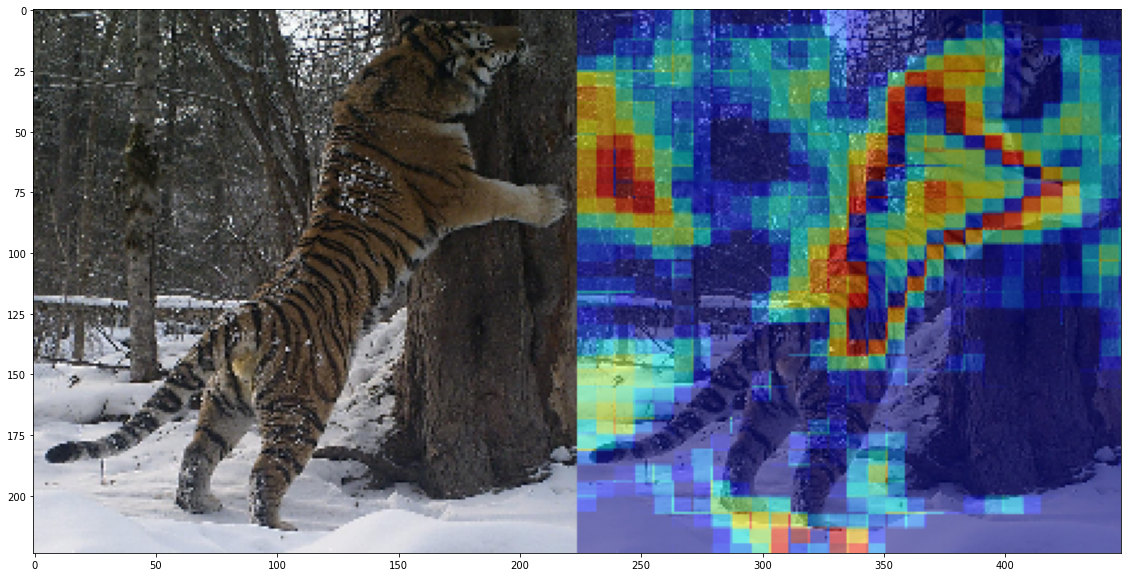

In [39]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

plt.figure(figsize = (20,10))

#Show the image with matplotlib
plt.imshow(vis)
plt.show()

In [7]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )


def vis_img(img):
    transformed_img = transform(img)

    input = transform_normalize(transformed_img)
    input = input.unsqueeze(0)
    #input = input.cuda()
    output = model(input)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    #predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                     [(0, '#ffffff'),
                                                      (0.25, '#000000'),
                                                      (1, '#000000')], N=256)

    _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap=default_cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1)

    noise_tunnel = NoiseTunnel(integrated_gradients)

    attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          cmap=default_cmap,
                                          show_colorbar=True)

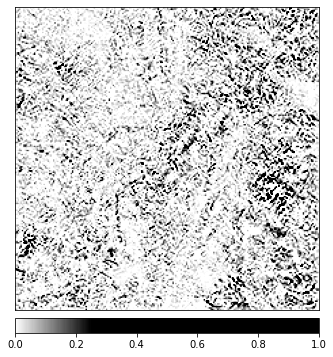

RuntimeError: [enforce fail at CPUAllocator.cpp:68] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 401408000 bytes. Error code 12 (Cannot allocate memory)

In [8]:
img = Image.open('/home/tesla/tigers_bbox/data/cropped/Тигры/001_1001.jpg')
vis_img(img)


